# Домашнее задание №4

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from Bio import SeqIO

## Задача №0 (3)
Дорешайте задачу про риды и BWT из файла practice4.ipynb. В ответе помимо кода укажите количество ридов первой, второй и третьей категории, а также вкратце опишите ход решения.


Это домашнее задание можно выполнять целиком в этом ноутбуке, либо алгоритмы написать в отдельном файле и импортировать сюда, для использования. В папке data лежат два файла islands.fasta и nonIslands.fasta. В них хранятся прочтения из CpG островков и из обычных участков генома соответственно, этими данными нужно будет воспользоваться в первом задании.

## Задача №1 (1)
Определите частоты генерации для каждого из нуклеотидов внутри CpG островков и вне их. Посчитайте так-же частоты для всех упорядоченных пар нуклеотидов и сравните частоту пары CG внутри островков и снаружи. Сделайте вывод. 

In [2]:
def counts2freqs(counter):
    return {k: v / counter.total() for k, v in counter.items()}


def char_freqs(fasta_file):
    single = Counter()
    pairs = Counter()
    for rec in SeqIO.parse(fasta_file, format="fasta"):
        single.update(rec.seq)
        pairs.update(''.join(p) for p in zip(rec.seq, rec.seq[1:]))
    return counts2freqs(single), counts2freqs(pairs)

In [3]:
df_single = pd.DataFrame()
df_pairs = pd.DataFrame()

for region in ["nonIslands", "islands"]:
    c, cc = char_freqs(f"data/{region}.fasta")
    df_single[region] = c
    df_pairs[region] = cc

In [4]:
df_single

,nonIslands,islands
C,0.196136,0.296397
T,0.316117,0.202864
G,0.198448,0.298277
A,0.289299,0.202462


In [5]:
df_pairs

,nonIslands,islands
CT,0.072658,0.071749
TG,0.072865,0.063832
GG,0.050115,0.103559
GA,0.060233,0.059875
AT,0.082098,0.033418
TC,0.064758,0.059529
CC,0.050016,0.102793
TA,0.071005,0.028454
AG,0.070191,0.071924
AC,0.047130,0.045893


Внутри CpG-островков действительно повышенное содержание C и G нуклеотидов по сравнению с остальным геномом. Более того, частота пары CG на порядок (в 10-11 раз) выше внутри островков.

## Задача №2 (2)
Напишите марковскую модель, которая имеет открытые состояния {A, T, G, C}, и скрытые состояния {+, -}. Когда модель в состоянии **+**, то вероятность генерации некоторого символа нуклеотида соответствует его частоте внутри CpG островков, вычислиному в первом задании, если состояние **-**, то частоте вне островков. Вероятность остаться внутри островка 0.95, а перейти в обычный геном 0.05. Для остальной части генома соответствующие вероятности 0.995 и 0.005. Саму модель можно реализовать в виде итератора, определив метод next, который возвращает пару - состояние и нуклеотид, который в этом состоянии произведен.    
Воспользуйтесь данной моделью для того чтобы сгенерировать набор из 20 последовательностей длинной от 1 000 до 100 000, причем к каждой последовательности должна прилагаться последовательность состояний.

In [6]:
def gen(pi, A, B, seed=None):
    rng = np.random.default_rng(seed=seed)
    hidden_state = rng.choice(2, p=pi)
    while True:
        yield hidden_state, rng.choice(B.index, p=B[hidden_state])
        hidden_state = rng.choice(2, p=A[hidden_state])

In [7]:
pi = np.array([0.5, 0.5])
A = np.array([
    [0.995, 0.005],
    [0.05, 0.95],
])
B = df_single.rename(columns={"nonIslands": 0, "islands": 1}, inplace=False)

In [8]:
from tqdm.notebook import trange

seqs = []

for _ in trange(20):
    g = gen(pi, A, B)
    length = np.random.randint(1_000, 100_000)

    seq = []
    hidden_states = []
    for i in range(length):
        hs, nucl = next(g)
        seq.append(nucl)
        hidden_states.append(hs)
    
    seqs.append((''.join(seq), hidden_states))

  0%|          | 0/20 [00:00<?, ?it/s]

## Задача №3 (4)
Напишите алгоритм Витерби для восстановления последовательности скрытых состояний марковской модели из второго задаания. Воспользуйтесь им, воссстановив состояния тех последовательностей, которые вы получили во втором задании и посчитайте TP, TN, FP, FN по количеству правильно или ошибочно предсказанных позиций из CpG остравков. 

In [9]:
def calc_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    tp = np.sum(np.logical_and(y_true == 1, y_pred == 1))
    tn = np.sum(np.logical_and(y_true == 0, y_pred == 0))
    fp = np.sum(np.logical_and(y_true == 0, y_pred == 1))
    fn = np.sum(np.logical_and(y_true == 1, y_pred == 0))
    precision = 0 if tp == 0 else tp / (tp + fp)
    recall = 0 if tp == 0 else tp / (tp + fn)
    return tp, tn, fp, fn, precision, recall

In [10]:
from inference import viterbi

nucl_encode = {c: i for i, c in enumerate(B.index)}

for i, (seq, hidden_states) in enumerate(seqs):
    seq_encoded = np.array([nucl_encode[nucl] for nucl in seq])
    mle_states, _ = viterbi(pi, A, B.to_numpy().T, seq_encoded)
    tp, tn, fp, fn, precision, recall = calc_metrics(hidden_states, mle_states)
    print(f"\nFor seq #{i + 1}:")
    print(f"TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}")
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}")


For seq #1:
TP = 16, TN = 6648, FP = 26, FN = 730
Precision: 0.381, Recall: 0.021

For seq #2:
TP = 168, TN = 35801, FP = 23, FN = 3477
Precision: 0.880, Recall: 0.046

For seq #3:
TP = 62, TN = 33461, FP = 0, FN = 2925
Precision: 1.000, Recall: 0.021

For seq #4:
TP = 395, TN = 65725, FP = 49, FN = 5789
Precision: 0.890, Recall: 0.064

For seq #5:
TP = 124, TN = 57137, FP = 13, FN = 5968
Precision: 0.905, Recall: 0.020

For seq #6:
TP = 0, TN = 12414, FP = 0, FN = 1525
Precision: 0.000, Recall: 0.000

For seq #7:
TP = 460, TN = 54983, FP = 56, FN = 5221
Precision: 0.891, Recall: 0.081

For seq #8:
TP = 404, TN = 42160, FP = 13, FN = 4091
Precision: 0.969, Recall: 0.090

For seq #9:
TP = 156, TN = 72066, FP = 45, FN = 7044
Precision: 0.776, Recall: 0.022

For seq #10:
TP = 517, TN = 85398, FP = 128, FN = 7964
Precision: 0.802, Recall: 0.061

For seq #11:
TP = 250, TN = 77124, FP = 130, FN = 7198
Precision: 0.658, Recall: 0.034

For seq #12:
TP = 307, TN = 36687, FP = 118, FN = 3553
Pr

## Задача №4 (4)
Напишите алгоритм вперед назад для модели из второго задания. Пользуясь этим алгоритмом найдите вероятности того, что модель находилась в состоянии **+** для каждой позиции строк из второго задания. Устанавливая различные пороговые значения, определите позиции соответствующие CpG островкам и посчитайте TP. Постройте график зависимости TP от выбранного порогового значения. Есть ли пороговые значения при которых TP больше чем в задании №3?

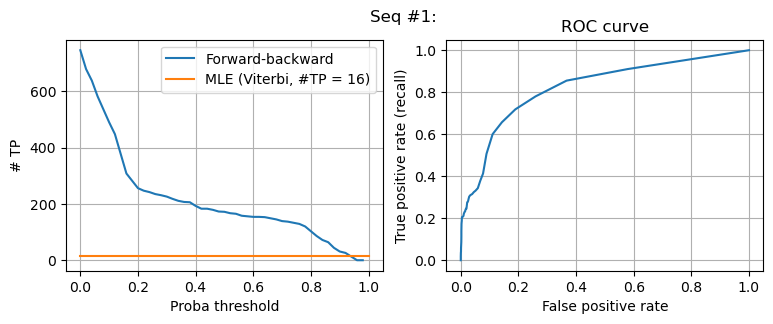

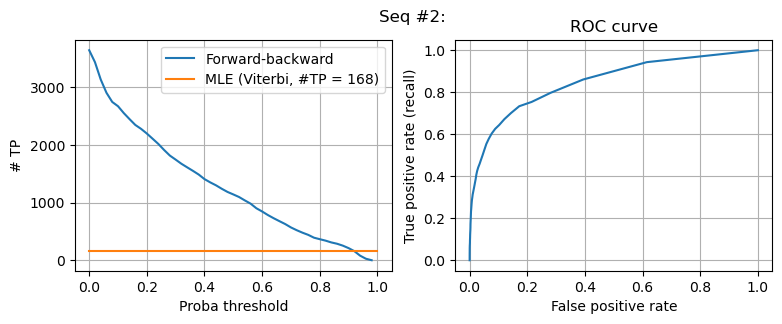

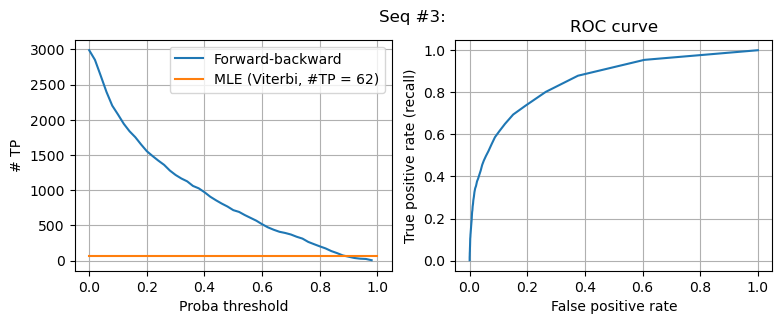

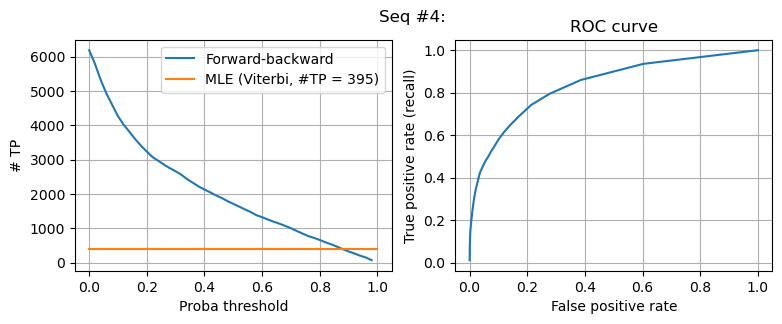

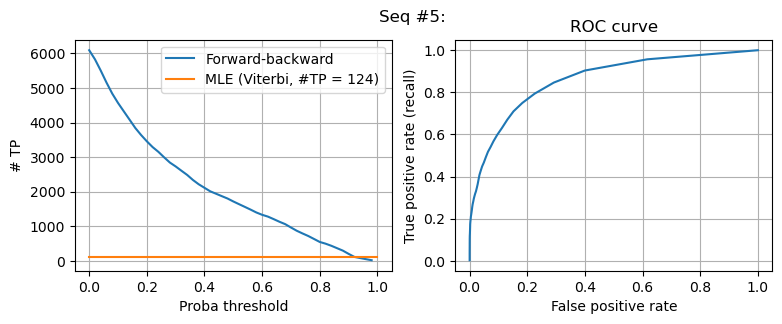

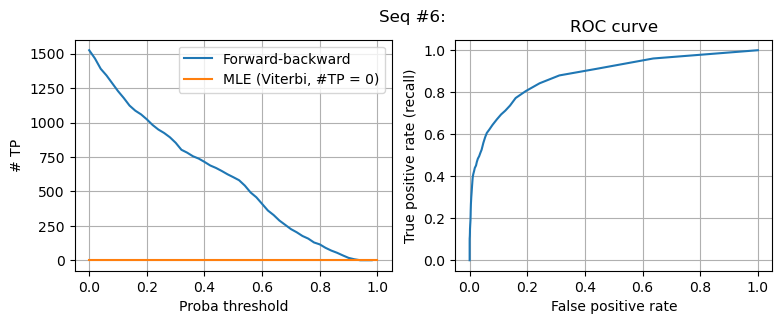

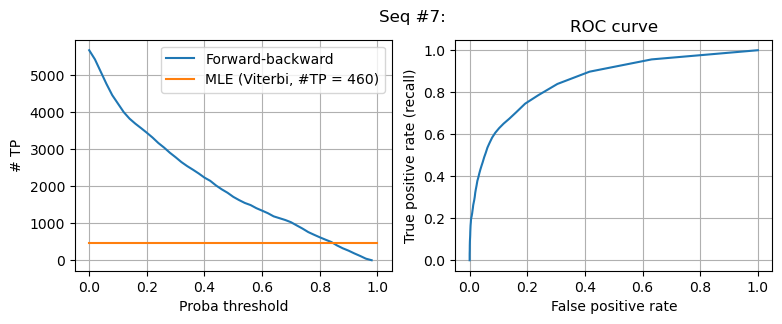

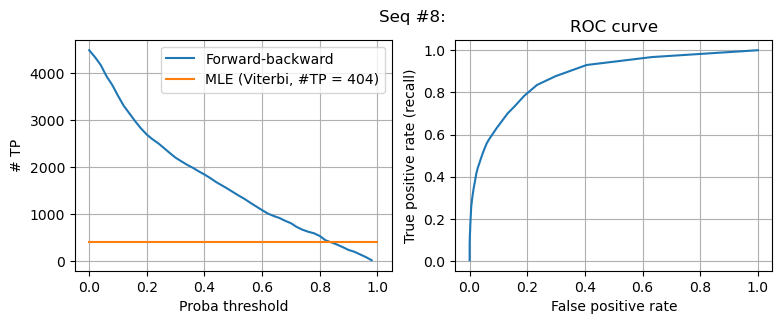

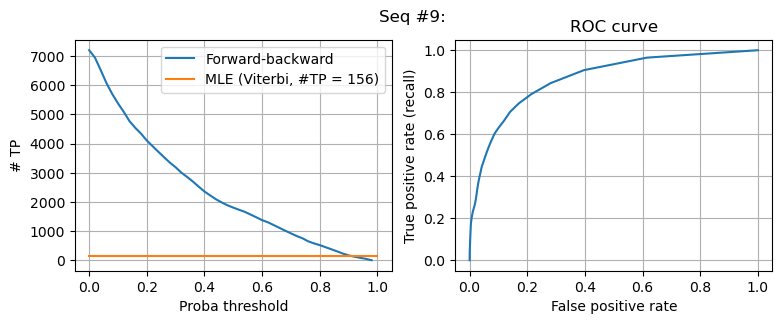

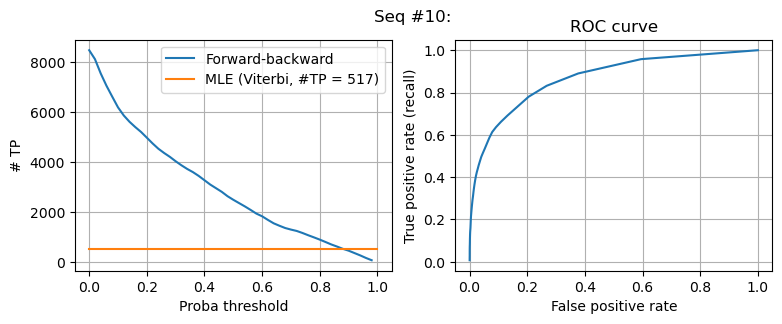

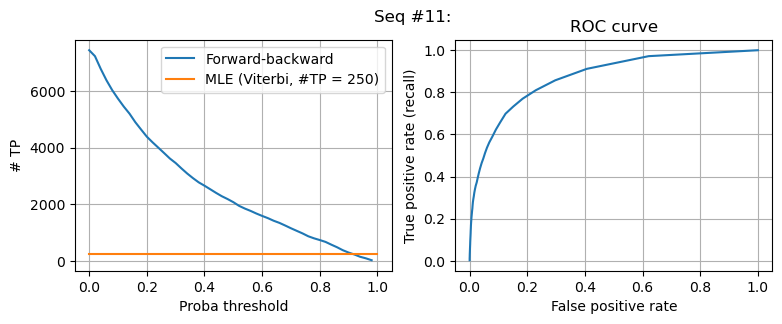

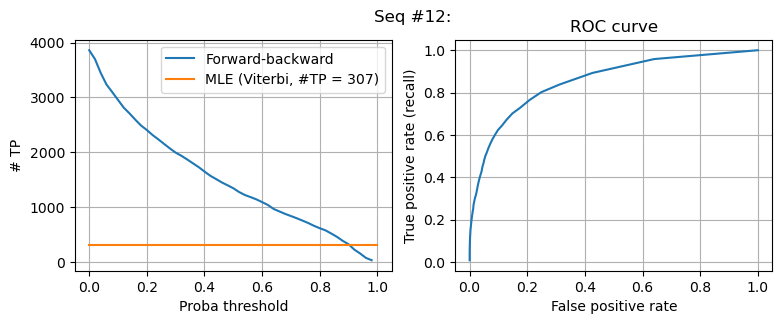

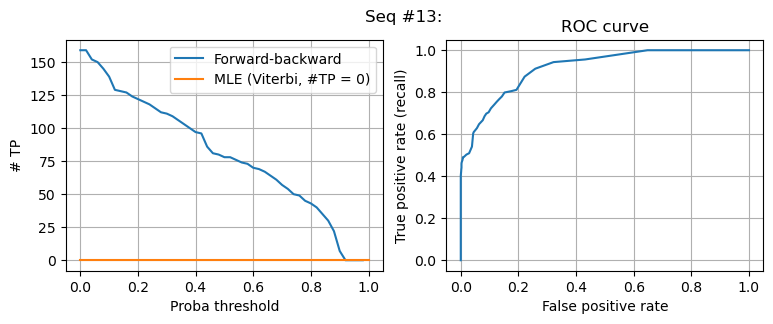

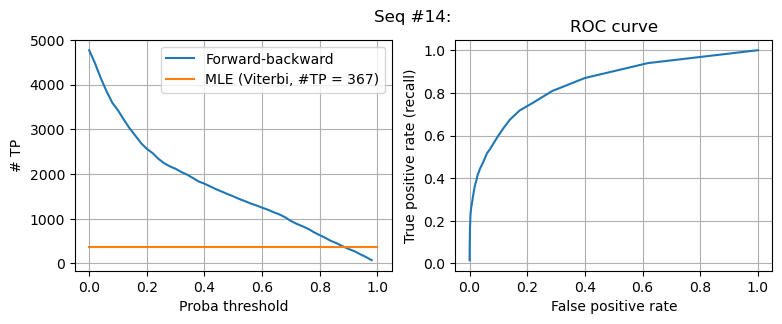

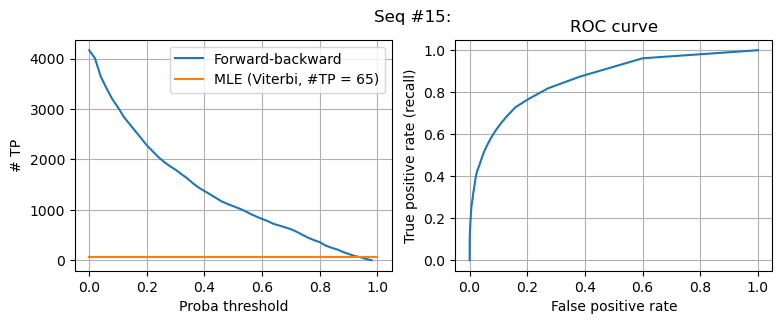

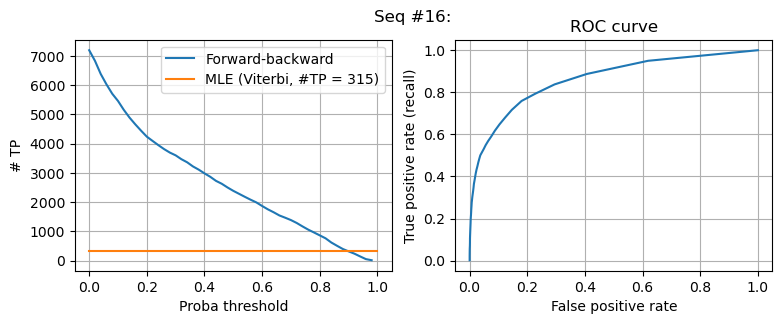

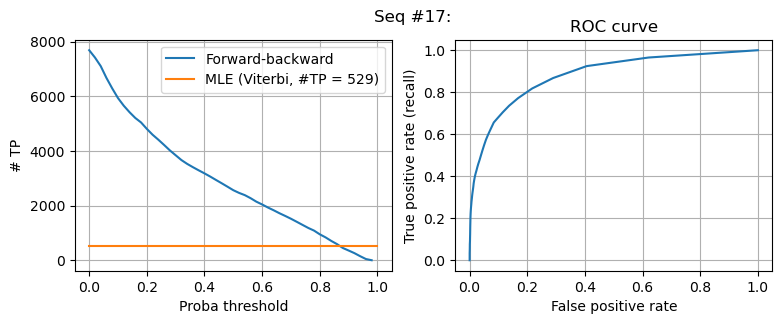

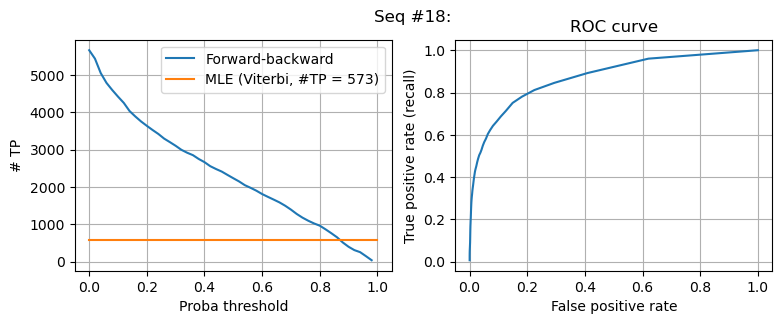

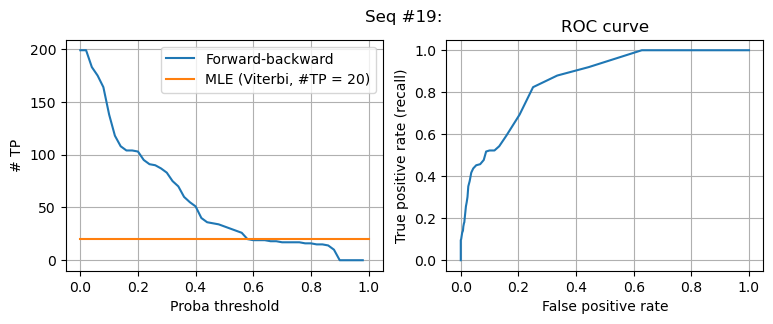

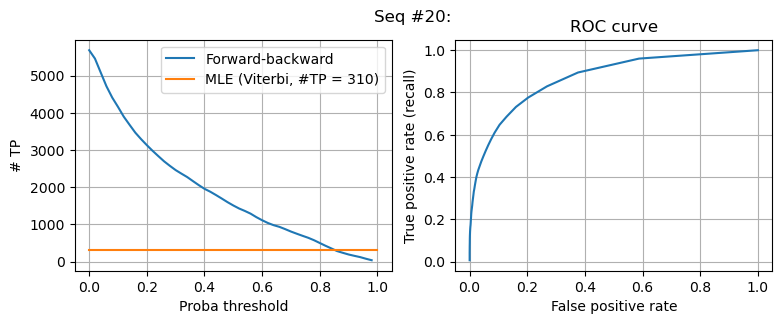

In [11]:
from likelihood import forward_backward
import matplotlib.pyplot as plt

nucl_encode = {c: i for i, c in enumerate(B.index)}
thres = np.linspace(0, 1, 50, endpoint=False)

for i, (seq, hidden_states) in enumerate(seqs):
    seq_encoded = np.array([nucl_encode[nucl] for nucl in seq])
    log_probs, _ = forward_backward(pi, A, B.to_numpy().T, seq_encoded)
    probs = np.exp(log_probs)
    
    tps = []
    roc = []
    for t in thres:
        tp, tn, fp, fn, precision, recall = calc_metrics(hidden_states, probs[:, 1] >= t)
        fpr = 0 if fp == 0 else fp / (fp + tn)
        tps.append(tp)
        roc.append([fpr, recall])
    roc = np.array(roc)

    mle_states, _ = viterbi(pi, A, B.to_numpy().T, seq_encoded)
    tp, tn, fp, fn, precision, recall = calc_metrics(hidden_states, mle_states)
    
    fig, axs = plt.subplots(1, 2, figsize=(9, 3))
    fig.suptitle(f"Seq #{i + 1}:")
    axs[0].plot(thres, tps, label="Forward-backward")
    axs[0].plot([0.0, 1.0], [tp, tp], label=f"MLE (Viterbi, #TP = {tp})")
    axs[0].set_xlabel("Proba threshold")
    axs[0].set_ylabel("# TP")
    axs[0].grid()
    axs[0].legend()
    axs[1].plot(roc[:, 0], roc[:, 1])
    axs[1].set_title("ROC curve")
    axs[1].set_xlabel("False positive rate")
    axs[1].set_ylabel("True positive rate (recall)")
    axs[1].grid()
    plt.show()